In [ ]:
import pandas as pd
full_dataset=pd.read_csv("/kaggle/input/english-to-bangla-translation/english_bangla_translation.csv")
full_dataset.head()

,english,bangla
0,"Hello, good to see you!","হ্যালো, আপনাকে দেখে ভালো লাগলো!"
1,"Goodbye, have a great day!","বিদায়, আপনার দিন শুভ হোক!"
2,Thank you very much for your help.,আপনার সহায়তার জন্য অনেক ধন্যবাদ।
3,I appreciate it.,আমি এটি প্রশংসা করি।
4,You're welcome!,আপনার স্বাগতম!


In [2]:
full_dataset.shape

(159065, 2)

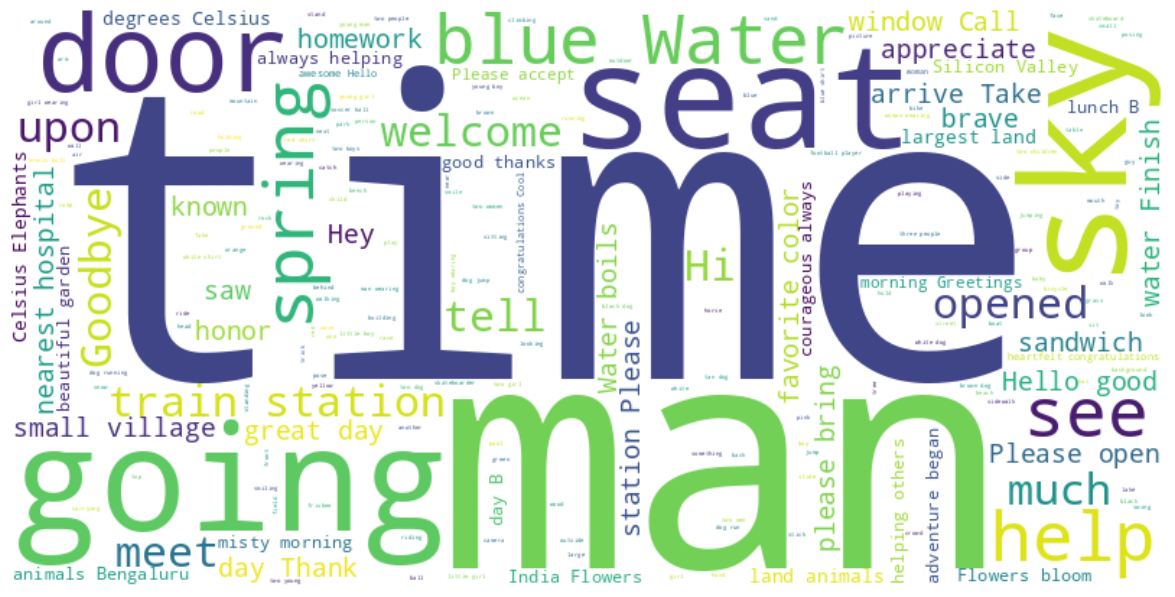

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

english_text = ' '.join(full_dataset['english'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(english_text)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

# Vocabulary building for Language Translation

How counter keeps track of word frequencies

In [4]:
from collections import Counter
counter = Counter()

for i in range(1,10):
    counter.update("Hello I am fine".split())

In [5]:
counter.most_common(10)

[('Hello', 9), ('I', 9), ('am', 9), ('fine', 9)]

In [6]:
from collections import Counter

def tokenize(text):
    return text.strip().split() 

SPECIAL_TOKENS = ["<pad>", "<sos>", "<eos>", "<unk>"]

def build_vocab(sentences, min_freq=1):
    counter = Counter()
    for s in sentences:
        counter.update(tokenize(str(s)))

    vocab = {tok: idx for idx, tok in enumerate(SPECIAL_TOKENS)} # add the special tokens first with reserved indices
    for token, freq in counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = len(vocab)
    idx2word = {idx: tok for tok, idx in vocab.items()}
    return vocab, idx2word

In [7]:
source_sentences = full_dataset['english'].astype(str).tolist()
target_sentences = full_dataset['bangla'].astype(str).tolist()

target_sentences = full_dataset['bangla'].astype(str).tolist()

src_vocab, src_idx2word = build_vocab(source_sentences)
tgt_vocab, tgt_idx2word = build_vocab(target_sentences)

len(src_vocab), len(tgt_vocab)

(8919, 17407)

# Transformer Architecture

In [8]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self,embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads  # Integer division to ensure head_dim is an integer
        
        assert (self.head_dim * heads == embed_size),  "Embedding size needs to be divisible by heads"
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        
    def forward(self, values, keys, query, mask):
        N = query.shape[0] # Number of examples in the batch
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        
        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)
        
        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)        # (N, key_len, heads, head_dim)
        queries = self.queries(queries)  # (N, query_len, heads, head_dim)
        
        # Einsum does batch matrix multiplication for query*keys for each training example
        # we have query shape: (N, query_len, heads, head_dim) and key shape: (N, key_len, heads, head_dim)
        # we want to multiply the metrics in the way where n is batch size, h is heads, q is query_len and k is key_len
        # finally we get energy shape: (N, heads, query_len, key_len) = nhqk 
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)  # Normalize on the last axis (key_len)
        
        out = torch.einsum("nhqk,nkhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        
        out = self.fc_out(out)
        
        return out

## Self-Attention (Deep Dive with an Intuitive Example)

Self-attention lets each token **look at every other token** in the sequence and decide how much each other token should influence its representation. It does this by creating three vectors for every token: **Query (Q)**, **Key (K)**, and **Value (V)**.

### Intuition with a simple example

Sentence: **“the animal didn’t cross the street because it was tired.”**

The word **“it”** could refer to *animal* or *street*. Self-attention helps the model figure out it refers to **animal** by assigning higher attention weight from **“it”** to **“animal”** than to **“street.”**

So, the representation of **“it”** becomes a weighted mix of other words, mostly influenced by **“animal.”**

---
### What happens mathematically
1. **Embed tokens** into vectors (size = $d_{model}$).
2. **Project each embedding into Q, K, V** with learned matrices.
   $$Q = XW_Q,\quad K = XW_K,\quad V = XW_V$$
3. **Compute similarity scores** between each query and all keys:
   $$\text{score}(i, j) = \frac{Q_i \cdot K_j}{\sqrt{d_k}}$$
4. **Mask (optional)** future tokens (decoder) or padding tokens.
5. **Softmax** to turn scores into probabilities:
   $$\alpha_{i,j} = \text{softmax}(\text{score}(i, j))$$
6. **Weighted sum of values** gives new token representation:
   $$\text{Attention}(Q, K, V) = \alpha V$$

---
### How this maps to your `SelfAttention` code
Your block does the same steps:
- Splits embeddings into multiple heads (`self.heads`)
- Projects into Q/K/V using `nn.Linear`
- Uses `einsum` to compute similarity
- Applies softmax to get attention weights
- Mixes values back and concatenates heads

---
### Why multiple heads?
Multiple heads let the model **attend to different relationships** at the same time.
For example:
- Head 1 might connect **pronouns → nouns**
- Head 2 might capture **verb-object relations**
- Head 3 might focus on **local word order**

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        
        # Add & Norm
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        
        # Add & Norm
        out = self.dropout(self.norm2(forward + x))
        return out


In [10]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            out = layer(out, out, out, mask)
        
        return out


In [11]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In [12]:
class Decoder(nn.Module):
    def __init__(
        self,
        tgt_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)
            ]
        )
        
        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)
        
        out = self.fc_out(x)
        
        return out

In [13]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        src_pad_idx,
        tgt_pad_idx,
        embed_size=256,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="cuda",
        max_length=100,
    ):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )
        
        self.decoder = Decoder(
            tgt_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length,
        )
        
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)
    
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out

## Dataset Preparation & DataLoader

Now we'll prepare the dataset and create PyTorch DataLoaders for batch training.

In [14]:
from torch.utils.data import Dataset, DataLoader
import random

# Convert sentences to token IDs
def encode_sentence(sentence, vocab, max_len=50):
    tokens = tokenize(str(sentence))
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    
    # Add start token
    ids = [vocab["<sos>"]] + ids
    
    # Truncate or pad
    if len(ids) > max_len - 1:
        ids = ids[:max_len - 1]
    
    # Add end token
    ids = ids + [vocab["<eos>"]]
    
    # Pad to max_len
    if len(ids) < max_len:
        ids = ids + [vocab["<pad>"]] * (max_len - len(ids))
    
    return ids[:max_len]

# Create parallel dataset
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len=50):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.src_sentences)
    
    def __getitem__(self, idx):
        src = encode_sentence(self.src_sentences[idx], self.src_vocab, self.max_len)
        tgt = encode_sentence(self.tgt_sentences[idx], self.tgt_vocab, self.max_len)
        
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

# Create dataset and dataloaders
MAX_LEN = 50
BATCH_SIZE = 32

# Train-val split
data_size = len(source_sentences)
indices = list(range(data_size))
random.shuffle(indices)
train_split = int(0.9 * data_size)

train_indices = indices[:train_split]
val_indices = indices[train_split:]

train_src = [source_sentences[i] for i in train_indices]
train_tgt = [target_sentences[i] for i in train_indices]
val_src = [source_sentences[i] for i in val_indices]
val_tgt = [target_sentences[i] for i in val_indices]

# Create datasets
train_dataset = TranslationDataset(train_src, train_tgt, src_vocab, tgt_vocab, MAX_LEN)
val_dataset = TranslationDataset(val_src, val_tgt, src_vocab, tgt_vocab, MAX_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training samples: 143158
Validation samples: 15907
Training batches: 4474
Validation batches: 498


## Model Initialization & Training Setup

Initialize the Transformer model, optimizer, and loss function.

In [15]:
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Hyperparameters
embed_size = 256
num_layers = 4
forward_expansion = 4
heads = 8
dropout = 0.1
learning_rate = 3e-4
num_epochs = 30

# Initialize model
model = Transformer(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_pad_idx=src_vocab["<pad>"],
    tgt_pad_idx=tgt_vocab["<pad>"],
    embed_size=embed_size,
    num_layers=num_layers,
    forward_expansion=forward_expansion,
    heads=heads,
    dropout=dropout,
    device=device,
    max_length=MAX_LEN,
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nModel initialized with:")
print(f"  Source vocab size: {len(src_vocab)}")
print(f"  Target vocab size: {len(tgt_vocab)}")
print(f"  Embedding size: {embed_size}")
print(f"  Num layers: {num_layers}")
print(f"  Num heads: {heads}")

Device: cuda

Model initialized with:
  Source vocab size: 8919
  Target vocab size: 17407
  Embedding size: 256
  Num layers: 4
  Num heads: 8


## Training Loop

Train the Transformer model on the dataset.

In [16]:
from tqdm import tqdm

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    
    for idx, (src, trg) in enumerate(tqdm(iterator)):
        src = src.to(device)
        trg = trg.to(device)
        
        # Forward pass
        output = model(src, trg[:, :-1])  # Exclude last token from decoder input
        
        # Reshape for loss computation
        output = output.reshape(-1, output.shape[2])
        trg = trg[:, 1:].reshape(-1)  # Exclude first token (start token)
        
        # Backward pass
        optimizer.zero_grad()
        loss = criterion(output, trg)
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if (idx + 1) % 50 == 0:
            print(f"  Batch {idx + 1}/{len(iterator)} - Loss: {loss.item():.4f}")
    
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, trg in tqdm(iterator):
            src = src.to(device)
            trg = trg.to(device)
            
            output = model(src, trg[:, :-1])
            
            output = output.reshape(-1, output.shape[2])
            trg = trg[:, 1:].reshape(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("\n✓ Training complete!")


Epoch 1/5


  1%|          | 55/4474 [00:02<02:54, 25.27it/s] 

  Batch 50/4474 - Loss: 5.2772


  2%|▏         | 103/4474 [00:04<02:51, 25.49it/s]

  Batch 100/4474 - Loss: 3.7925


  3%|▎         | 154/4474 [00:06<02:48, 25.61it/s]

  Batch 150/4474 - Loss: 2.4748


  5%|▍         | 205/4474 [00:08<02:46, 25.60it/s]

  Batch 200/4474 - Loss: 2.1088


  6%|▌         | 253/4474 [00:10<02:44, 25.58it/s]

  Batch 250/4474 - Loss: 3.1117


  7%|▋         | 304/4474 [00:12<02:44, 25.43it/s]

  Batch 300/4474 - Loss: 2.6687


  8%|▊         | 355/4474 [00:14<02:42, 25.35it/s]

  Batch 350/4474 - Loss: 0.8320


  9%|▉         | 403/4474 [00:16<02:38, 25.73it/s]

  Batch 400/4474 - Loss: 1.9934


 10%|█         | 454/4474 [00:18<02:37, 25.59it/s]

  Batch 450/4474 - Loss: 1.3372


 11%|█▏        | 505/4474 [00:20<02:36, 25.39it/s]

  Batch 500/4474 - Loss: 1.6852


 12%|█▏        | 553/4474 [00:22<02:31, 25.85it/s]

  Batch 550/4474 - Loss: 1.7710


 14%|█▎        | 604/4474 [00:24<02:29, 25.81it/s]

  Batch 600/4474 - Loss: 0.9097


 15%|█▍        | 655/4474 [00:26<02:29, 25.56it/s]

  Batch 650/4474 - Loss: 1.1807


 16%|█▌        | 703/4474 [00:28<02:26, 25.71it/s]

  Batch 700/4474 - Loss: 2.0269


 17%|█▋        | 754/4474 [00:30<02:24, 25.80it/s]

  Batch 750/4474 - Loss: 2.3844


 18%|█▊        | 805/4474 [00:32<02:23, 25.57it/s]

  Batch 800/4474 - Loss: 1.9568


 19%|█▉        | 853/4474 [00:34<02:20, 25.69it/s]

  Batch 850/4474 - Loss: 2.3129


 20%|██        | 904/4474 [00:36<02:20, 25.36it/s]

  Batch 900/4474 - Loss: 2.2042


 21%|██▏       | 955/4474 [00:38<02:17, 25.63it/s]

  Batch 950/4474 - Loss: 1.3459


 22%|██▏       | 1003/4474 [00:39<02:15, 25.64it/s]

  Batch 1000/4474 - Loss: 1.5828


 24%|██▎       | 1054/4474 [00:41<02:13, 25.61it/s]

  Batch 1050/4474 - Loss: 2.3576


 25%|██▍       | 1105/4474 [00:43<02:13, 25.26it/s]

  Batch 1100/4474 - Loss: 2.7647


 26%|██▌       | 1153/4474 [00:45<02:12, 25.14it/s]

  Batch 1150/4474 - Loss: 1.0326


 27%|██▋       | 1204/4474 [00:47<02:07, 25.55it/s]

  Batch 1200/4474 - Loss: 2.1961


 28%|██▊       | 1255/4474 [00:49<02:05, 25.68it/s]

  Batch 1250/4474 - Loss: 0.2270


 29%|██▉       | 1303/4474 [00:51<02:02, 25.82it/s]

  Batch 1300/4474 - Loss: 1.9773


 30%|███       | 1354/4474 [00:53<02:01, 25.61it/s]

  Batch 1350/4474 - Loss: 1.7877


 31%|███▏      | 1405/4474 [00:55<02:00, 25.43it/s]

  Batch 1400/4474 - Loss: 1.8911


 32%|███▏      | 1453/4474 [00:57<01:57, 25.72it/s]

  Batch 1450/4474 - Loss: 1.2794


 34%|███▎      | 1504/4474 [00:59<01:56, 25.58it/s]

  Batch 1500/4474 - Loss: 1.9658


 35%|███▍      | 1555/4474 [01:01<01:54, 25.59it/s]

  Batch 1550/4474 - Loss: 1.4493


 36%|███▌      | 1603/4474 [01:03<01:51, 25.71it/s]

  Batch 1600/4474 - Loss: 2.3579


 37%|███▋      | 1654/4474 [01:05<01:50, 25.46it/s]

  Batch 1650/4474 - Loss: 2.1869


 38%|███▊      | 1705/4474 [01:07<01:48, 25.58it/s]

  Batch 1700/4474 - Loss: 2.2321


 39%|███▉      | 1753/4474 [01:09<01:45, 25.78it/s]

  Batch 1750/4474 - Loss: 1.7477


 40%|████      | 1804/4474 [01:11<01:43, 25.89it/s]

  Batch 1800/4474 - Loss: 1.1280


 41%|████▏     | 1855/4474 [01:13<01:42, 25.50it/s]

  Batch 1850/4474 - Loss: 1.4953


 43%|████▎     | 1903/4474 [01:15<01:39, 25.71it/s]

  Batch 1900/4474 - Loss: 1.0490


 44%|████▎     | 1954/4474 [01:17<01:38, 25.67it/s]

  Batch 1950/4474 - Loss: 1.1346


 45%|████▍     | 2005/4474 [01:19<01:36, 25.61it/s]

  Batch 2000/4474 - Loss: 1.7517


 46%|████▌     | 2053/4474 [01:21<01:34, 25.64it/s]

  Batch 2050/4474 - Loss: 1.5888


 47%|████▋     | 2104/4474 [01:23<01:32, 25.61it/s]

  Batch 2100/4474 - Loss: 1.5223


 48%|████▊     | 2155/4474 [01:24<01:29, 25.78it/s]

  Batch 2150/4474 - Loss: 2.2629


 49%|████▉     | 2203/4474 [01:26<01:28, 25.80it/s]

  Batch 2200/4474 - Loss: 1.1461


 50%|█████     | 2254/4474 [01:28<01:26, 25.71it/s]

  Batch 2250/4474 - Loss: 1.6890


 52%|█████▏    | 2305/4474 [01:30<01:24, 25.59it/s]

  Batch 2300/4474 - Loss: 1.8409


 53%|█████▎    | 2353/4474 [01:32<01:22, 25.78it/s]

  Batch 2350/4474 - Loss: 2.0732


 54%|█████▎    | 2404/4474 [01:34<01:19, 25.92it/s]

  Batch 2400/4474 - Loss: 1.0276


 55%|█████▍    | 2455/4474 [01:36<01:18, 25.67it/s]

  Batch 2450/4474 - Loss: 1.6474


 56%|█████▌    | 2503/4474 [01:38<01:17, 25.55it/s]

  Batch 2500/4474 - Loss: 1.6846


 57%|█████▋    | 2554/4474 [01:40<01:15, 25.56it/s]

  Batch 2550/4474 - Loss: 1.9569


 58%|█████▊    | 2605/4474 [01:42<01:12, 25.80it/s]

  Batch 2600/4474 - Loss: 1.6876


 59%|█████▉    | 2653/4474 [01:44<01:10, 25.77it/s]

  Batch 2650/4474 - Loss: 2.5523


 60%|██████    | 2704/4474 [01:46<01:09, 25.42it/s]

  Batch 2700/4474 - Loss: 0.9416


 62%|██████▏   | 2755/4474 [01:48<01:06, 25.94it/s]

  Batch 2750/4474 - Loss: 2.1034


 63%|██████▎   | 2803/4474 [01:50<01:04, 25.83it/s]

  Batch 2800/4474 - Loss: 2.0099


 64%|██████▍   | 2854/4474 [01:52<01:03, 25.53it/s]

  Batch 2850/4474 - Loss: 2.4277


 65%|██████▍   | 2905/4474 [01:54<01:01, 25.34it/s]

  Batch 2900/4474 - Loss: 1.6725


 66%|██████▌   | 2953/4474 [01:56<00:59, 25.41it/s]

  Batch 2950/4474 - Loss: 1.7298


 67%|██████▋   | 3004/4474 [01:58<00:57, 25.69it/s]

  Batch 3000/4474 - Loss: 1.3322


 68%|██████▊   | 3055/4474 [02:00<00:55, 25.68it/s]

  Batch 3050/4474 - Loss: 2.5812


 69%|██████▉   | 3103/4474 [02:01<00:52, 25.93it/s]

  Batch 3100/4474 - Loss: 1.8933


 70%|███████   | 3154/4474 [02:03<00:51, 25.56it/s]

  Batch 3150/4474 - Loss: 0.9978


 72%|███████▏  | 3202/4474 [02:05<00:51, 24.89it/s]

  Batch 3200/4474 - Loss: 1.9888


 73%|███████▎  | 3253/4474 [02:07<00:47, 25.67it/s]

  Batch 3250/4474 - Loss: 2.5181


 74%|███████▍  | 3304/4474 [02:09<00:45, 25.80it/s]

  Batch 3300/4474 - Loss: 1.3613


 75%|███████▍  | 3355/4474 [02:11<00:43, 25.76it/s]

  Batch 3350/4474 - Loss: 0.9798


 76%|███████▌  | 3403/4474 [02:13<00:41, 25.61it/s]

  Batch 3400/4474 - Loss: 1.5344


 77%|███████▋  | 3454/4474 [02:15<00:39, 25.86it/s]

  Batch 3450/4474 - Loss: 2.4715


 78%|███████▊  | 3505/4474 [02:17<00:37, 25.85it/s]

  Batch 3500/4474 - Loss: 3.1224


 79%|███████▉  | 3553/4474 [02:19<00:35, 25.71it/s]

  Batch 3550/4474 - Loss: 1.1291


 81%|████████  | 3604/4474 [02:21<00:33, 25.71it/s]

  Batch 3600/4474 - Loss: 1.9626


 82%|████████▏ | 3655/4474 [02:23<00:32, 25.47it/s]

  Batch 3650/4474 - Loss: 1.5273


 83%|████████▎ | 3703/4474 [02:25<00:29, 25.87it/s]

  Batch 3700/4474 - Loss: 1.8852


 84%|████████▍ | 3754/4474 [02:27<00:27, 25.84it/s]

  Batch 3750/4474 - Loss: 1.3707


 85%|████████▌ | 3805/4474 [02:29<00:26, 25.73it/s]

  Batch 3800/4474 - Loss: 0.8405


 86%|████████▌ | 3853/4474 [02:31<00:24, 25.72it/s]

  Batch 3850/4474 - Loss: 1.4791


 87%|████████▋ | 3904/4474 [02:33<00:22, 25.58it/s]

  Batch 3900/4474 - Loss: 1.3999


 88%|████████▊ | 3955/4474 [02:35<00:20, 25.86it/s]

  Batch 3950/4474 - Loss: 1.6374


 89%|████████▉ | 4003/4474 [02:36<00:18, 25.76it/s]

  Batch 4000/4474 - Loss: 1.4034


 91%|█████████ | 4054/4474 [02:38<00:16, 25.77it/s]

  Batch 4050/4474 - Loss: 1.9186


 92%|█████████▏| 4105/4474 [02:40<00:14, 25.75it/s]

  Batch 4100/4474 - Loss: 2.1454


 93%|█████████▎| 4153/4474 [02:42<00:12, 25.74it/s]

  Batch 4150/4474 - Loss: 0.8628


 94%|█████████▍| 4204/4474 [02:44<00:10, 25.37it/s]

  Batch 4200/4474 - Loss: 1.2852


 95%|█████████▌| 4255/4474 [02:46<00:08, 25.48it/s]

  Batch 4250/4474 - Loss: 1.3848


 96%|█████████▌| 4303/4474 [02:48<00:06, 25.94it/s]

  Batch 4300/4474 - Loss: 1.0512


 97%|█████████▋| 4354/4474 [02:50<00:04, 25.83it/s]

  Batch 4350/4474 - Loss: 0.8020


 98%|█████████▊| 4405/4474 [02:52<00:02, 25.85it/s]

  Batch 4400/4474 - Loss: 1.0207


100%|█████████▉| 4453/4474 [02:54<00:00, 25.91it/s]

  Batch 4450/4474 - Loss: 1.0178


100%|██████████| 498/498 [00:06<00:00, 78.30it/s]


Train Loss: 1.8253 | Val Loss: 1.4553

Epoch 2/5


  1%|          | 54/4474 [00:02<02:55, 25.19it/s]

  Batch 50/4474 - Loss: 1.6059


  2%|▏         | 102/4474 [00:03<02:49, 25.84it/s]

  Batch 100/4474 - Loss: 1.7174


  3%|▎         | 153/4474 [00:05<02:48, 25.68it/s]

  Batch 150/4474 - Loss: 1.0768


  5%|▍         | 204/4474 [00:07<02:48, 25.39it/s]

  Batch 200/4474 - Loss: 2.0050


  6%|▌         | 255/4474 [00:09<02:44, 25.68it/s]

  Batch 250/4474 - Loss: 1.9027


  7%|▋         | 303/4474 [00:11<02:41, 25.80it/s]

  Batch 300/4474 - Loss: 1.2769


  8%|▊         | 354/4474 [00:13<02:41, 25.44it/s]

  Batch 350/4474 - Loss: 1.0168


  9%|▉         | 405/4474 [00:15<02:37, 25.80it/s]

  Batch 400/4474 - Loss: 1.7549


 10%|█         | 453/4474 [00:17<02:38, 25.43it/s]

  Batch 450/4474 - Loss: 0.9804


 11%|█▏        | 504/4474 [00:19<02:35, 25.54it/s]

  Batch 500/4474 - Loss: 1.5957


 12%|█▏        | 555/4474 [00:21<02:33, 25.51it/s]

  Batch 550/4474 - Loss: 1.4078


 13%|█▎        | 603/4474 [00:23<02:31, 25.56it/s]

  Batch 600/4474 - Loss: 0.8292


 15%|█▍        | 654/4474 [00:25<02:28, 25.66it/s]

  Batch 650/4474 - Loss: 0.9126


 16%|█▌        | 705/4474 [00:27<02:26, 25.65it/s]

  Batch 700/4474 - Loss: 1.4756


 17%|█▋        | 753/4474 [00:29<02:24, 25.78it/s]

  Batch 750/4474 - Loss: 2.2021


 18%|█▊        | 804/4474 [00:31<02:22, 25.68it/s]

  Batch 800/4474 - Loss: 1.9631


 19%|█▉        | 855/4474 [00:33<02:22, 25.45it/s]

  Batch 850/4474 - Loss: 2.3013


 20%|██        | 903/4474 [00:35<02:19, 25.63it/s]

  Batch 900/4474 - Loss: 2.4936


 21%|██▏       | 954/4474 [00:37<02:17, 25.58it/s]

  Batch 950/4474 - Loss: 1.8480


 22%|██▏       | 1005/4474 [00:39<02:15, 25.68it/s]

  Batch 1000/4474 - Loss: 1.5636


 24%|██▎       | 1053/4474 [00:41<02:14, 25.46it/s]

  Batch 1050/4474 - Loss: 0.8279


 25%|██▍       | 1104/4474 [00:43<02:11, 25.57it/s]

  Batch 1100/4474 - Loss: 2.0208


 26%|██▌       | 1155/4474 [00:45<02:10, 25.46it/s]

  Batch 1150/4474 - Loss: 0.8063


 27%|██▋       | 1203/4474 [00:47<02:07, 25.65it/s]

  Batch 1200/4474 - Loss: 1.4444


 28%|██▊       | 1254/4474 [00:49<02:07, 25.33it/s]

  Batch 1250/4474 - Loss: 1.2497


 29%|██▉       | 1305/4474 [00:51<02:04, 25.52it/s]

  Batch 1300/4474 - Loss: 1.6192


 30%|███       | 1353/4474 [00:52<02:00, 25.95it/s]

  Batch 1350/4474 - Loss: 0.9323


 31%|███▏      | 1404/4474 [00:54<02:00, 25.58it/s]

  Batch 1400/4474 - Loss: 1.0743


 33%|███▎      | 1455/4474 [00:56<01:58, 25.46it/s]

  Batch 1450/4474 - Loss: 0.8086


 34%|███▎      | 1503/4474 [00:58<01:56, 25.51it/s]

  Batch 1500/4474 - Loss: 2.3900


 35%|███▍      | 1554/4474 [01:00<01:52, 25.88it/s]

  Batch 1550/4474 - Loss: 1.9533


 36%|███▌      | 1605/4474 [01:02<01:52, 25.40it/s]

  Batch 1600/4474 - Loss: 0.9680


 37%|███▋      | 1653/4474 [01:04<01:50, 25.42it/s]

  Batch 1650/4474 - Loss: 2.1267


 38%|███▊      | 1704/4474 [01:06<01:47, 25.80it/s]

  Batch 1700/4474 - Loss: 1.8079


 39%|███▉      | 1755/4474 [01:08<01:46, 25.43it/s]

  Batch 1750/4474 - Loss: 1.7685


 40%|████      | 1803/4474 [01:10<01:44, 25.56it/s]

  Batch 1800/4474 - Loss: 1.3065


 41%|████▏     | 1854/4474 [01:12<01:42, 25.56it/s]

  Batch 1850/4474 - Loss: 1.3481


 43%|████▎     | 1905/4474 [01:14<01:40, 25.47it/s]

  Batch 1900/4474 - Loss: 1.1638


 44%|████▎     | 1953/4474 [01:16<01:37, 25.81it/s]

  Batch 1950/4474 - Loss: 0.7752


 45%|████▍     | 2004/4474 [01:18<01:36, 25.71it/s]

  Batch 2000/4474 - Loss: 1.4081


 46%|████▌     | 2055/4474 [01:20<01:33, 25.78it/s]

  Batch 2050/4474 - Loss: 1.6562


 47%|████▋     | 2103/4474 [01:22<01:34, 25.18it/s]

  Batch 2100/4474 - Loss: 1.7181


 48%|████▊     | 2154/4474 [01:24<01:32, 25.04it/s]

  Batch 2150/4474 - Loss: 0.3921


 49%|████▉     | 2205/4474 [01:26<01:28, 25.56it/s]

  Batch 2200/4474 - Loss: 1.9167


 50%|█████     | 2253/4474 [01:28<01:25, 25.85it/s]

  Batch 2250/4474 - Loss: 1.2275


 51%|█████▏    | 2304/4474 [01:30<01:25, 25.41it/s]

  Batch 2300/4474 - Loss: 1.9558


 53%|█████▎    | 2355/4474 [01:32<01:22, 25.76it/s]

  Batch 2350/4474 - Loss: 1.5786


 54%|█████▎    | 2403/4474 [01:33<01:20, 25.61it/s]

  Batch 2400/4474 - Loss: 1.1934


 55%|█████▍    | 2454/4474 [01:35<01:18, 25.73it/s]

  Batch 2450/4474 - Loss: 1.0553


 56%|█████▌    | 2505/4474 [01:37<01:16, 25.64it/s]

  Batch 2500/4474 - Loss: 0.8093


 57%|█████▋    | 2553/4474 [01:39<01:14, 25.76it/s]

  Batch 2550/4474 - Loss: 0.8186


 58%|█████▊    | 2604/4474 [01:41<01:13, 25.50it/s]

  Batch 2600/4474 - Loss: 1.3842


 59%|█████▉    | 2655/4474 [01:43<01:10, 25.70it/s]

  Batch 2650/4474 - Loss: 0.8057


 60%|██████    | 2703/4474 [01:45<01:08, 25.77it/s]

  Batch 2700/4474 - Loss: 1.0927


 62%|██████▏   | 2754/4474 [01:47<01:06, 25.73it/s]

  Batch 2750/4474 - Loss: 1.5181


 63%|██████▎   | 2805/4474 [01:49<01:04, 25.81it/s]

  Batch 2800/4474 - Loss: 1.6059


 64%|██████▍   | 2853/4474 [01:51<01:02, 25.89it/s]

  Batch 2850/4474 - Loss: 1.2673


 65%|██████▍   | 2904/4474 [01:53<01:01, 25.71it/s]

  Batch 2900/4474 - Loss: 1.5902


 66%|██████▌   | 2955/4474 [01:55<00:59, 25.60it/s]

  Batch 2950/4474 - Loss: 1.0606


 67%|██████▋   | 3003/4474 [01:57<00:57, 25.74it/s]

  Batch 3000/4474 - Loss: 1.5743


 68%|██████▊   | 3054/4474 [01:59<00:54, 25.86it/s]

  Batch 3050/4474 - Loss: 2.2146


 69%|██████▉   | 3105/4474 [02:01<00:53, 25.72it/s]

  Batch 3100/4474 - Loss: 1.7365


 70%|███████   | 3153/4474 [02:03<00:51, 25.51it/s]

  Batch 3150/4474 - Loss: 0.8295


 72%|███████▏  | 3204/4474 [02:05<00:49, 25.66it/s]

  Batch 3200/4474 - Loss: 1.0236


 73%|███████▎  | 3255/4474 [02:07<00:48, 25.23it/s]

  Batch 3250/4474 - Loss: 1.4546


 74%|███████▍  | 3303/4474 [02:09<00:45, 25.66it/s]

  Batch 3300/4474 - Loss: 0.5175


 75%|███████▍  | 3354/4474 [02:10<00:43, 25.70it/s]

  Batch 3350/4474 - Loss: 0.5963


 76%|███████▌  | 3405/4474 [02:12<00:41, 25.73it/s]

  Batch 3400/4474 - Loss: 0.8138


 77%|███████▋  | 3453/4474 [02:14<00:40, 25.31it/s]

  Batch 3450/4474 - Loss: 1.5577


 78%|███████▊  | 3504/4474 [02:16<00:37, 25.64it/s]

  Batch 3500/4474 - Loss: 1.0229


 79%|███████▉  | 3555/4474 [02:18<00:35, 25.76it/s]

  Batch 3550/4474 - Loss: 1.2451


 81%|████████  | 3603/4474 [02:20<00:33, 25.80it/s]

  Batch 3600/4474 - Loss: 1.3935


 82%|████████▏ | 3654/4474 [02:22<00:31, 25.65it/s]

  Batch 3650/4474 - Loss: 0.5863


 83%|████████▎ | 3705/4474 [02:24<00:30, 25.30it/s]

  Batch 3700/4474 - Loss: 0.5457


 84%|████████▍ | 3753/4474 [02:26<00:27, 25.79it/s]

  Batch 3750/4474 - Loss: 1.4667


 85%|████████▌ | 3804/4474 [02:28<00:26, 25.60it/s]

  Batch 3800/4474 - Loss: 1.2201


 86%|████████▌ | 3855/4474 [02:30<00:24, 25.56it/s]

  Batch 3850/4474 - Loss: 0.7129


 87%|████████▋ | 3903/4474 [02:32<00:22, 25.63it/s]

  Batch 3900/4474 - Loss: 0.9219


 88%|████████▊ | 3954/4474 [02:34<00:20, 25.23it/s]

  Batch 3950/4474 - Loss: 2.2751


 90%|████████▉ | 4005/4474 [02:36<00:18, 25.49it/s]

  Batch 4000/4474 - Loss: 1.5032


 91%|█████████ | 4053/4474 [02:38<00:16, 25.79it/s]

  Batch 4050/4474 - Loss: 1.2159


 92%|█████████▏| 4104/4474 [02:40<00:14, 25.45it/s]

  Batch 4100/4474 - Loss: 0.9594


 93%|█████████▎| 4155/4474 [02:42<00:12, 25.65it/s]

  Batch 4150/4474 - Loss: 1.7560


 94%|█████████▍| 4203/4474 [02:44<00:11, 24.31it/s]

  Batch 4200/4474 - Loss: 0.9292


 95%|█████████▌| 4254/4474 [02:46<00:08, 25.71it/s]

  Batch 4250/4474 - Loss: 1.3725


 96%|█████████▌| 4305/4474 [02:48<00:06, 25.78it/s]

  Batch 4300/4474 - Loss: 1.3663


 97%|█████████▋| 4353/4474 [02:50<00:04, 25.26it/s]

  Batch 4350/4474 - Loss: 1.1298


 98%|█████████▊| 4404/4474 [02:52<00:02, 25.73it/s]

  Batch 4400/4474 - Loss: 1.1785


100%|█████████▉| 4455/4474 [02:54<00:00, 25.55it/s]

  Batch 4450/4474 - Loss: 1.4618


100%|██████████| 498/498 [00:06<00:00, 79.31it/s]


Train Loss: 1.3769 | Val Loss: 1.3136

Epoch 3/5


  1%|          | 54/4474 [00:02<02:51, 25.81it/s]

  Batch 50/4474 - Loss: 1.2552


  2%|▏         | 105/4474 [00:04<02:52, 25.30it/s]

  Batch 100/4474 - Loss: 0.8382


  3%|▎         | 153/4474 [00:05<02:48, 25.60it/s]

  Batch 150/4474 - Loss: 0.5293


  5%|▍         | 204/4474 [00:07<02:48, 25.39it/s]

  Batch 200/4474 - Loss: 1.7250


  6%|▌         | 255/4474 [00:09<02:43, 25.79it/s]

  Batch 250/4474 - Loss: 1.7584


  7%|▋         | 303/4474 [00:11<02:41, 25.78it/s]

  Batch 300/4474 - Loss: 1.2465


  8%|▊         | 354/4474 [00:13<02:40, 25.64it/s]

  Batch 350/4474 - Loss: 0.8529


  9%|▉         | 405/4474 [00:15<02:37, 25.77it/s]

  Batch 400/4474 - Loss: 0.8376


 10%|█         | 453/4474 [00:17<02:36, 25.63it/s]

  Batch 450/4474 - Loss: 1.3310


 11%|█▏        | 504/4474 [00:19<02:35, 25.59it/s]

  Batch 500/4474 - Loss: 1.1418


 12%|█▏        | 555/4474 [00:21<02:33, 25.55it/s]

  Batch 550/4474 - Loss: 1.0385


 13%|█▎        | 603/4474 [00:23<02:31, 25.52it/s]

  Batch 600/4474 - Loss: 1.1895


 15%|█▍        | 654/4474 [00:25<02:29, 25.54it/s]

  Batch 650/4474 - Loss: 1.2221


 16%|█▌        | 705/4474 [00:27<02:28, 25.39it/s]

  Batch 700/4474 - Loss: 1.3568


 17%|█▋        | 753/4474 [00:29<02:24, 25.80it/s]

  Batch 750/4474 - Loss: 0.5981


 18%|█▊        | 804/4474 [00:31<02:23, 25.60it/s]

  Batch 800/4474 - Loss: 1.4902


 19%|█▉        | 855/4474 [00:33<02:23, 25.28it/s]

  Batch 850/4474 - Loss: 0.9912


 20%|██        | 903/4474 [00:35<02:18, 25.72it/s]

  Batch 900/4474 - Loss: 1.1046


 21%|██▏       | 954/4474 [00:37<02:16, 25.80it/s]

  Batch 950/4474 - Loss: 1.1942


 22%|██▏       | 1005/4474 [00:39<02:15, 25.56it/s]

  Batch 1000/4474 - Loss: 1.4986


 24%|██▎       | 1053/4474 [00:41<02:13, 25.64it/s]

  Batch 1050/4474 - Loss: 1.5125


 25%|██▍       | 1104/4474 [00:43<02:14, 24.99it/s]

  Batch 1100/4474 - Loss: 0.5445


 26%|██▌       | 1155/4474 [00:45<02:10, 25.49it/s]

  Batch 1150/4474 - Loss: 0.8401


 27%|██▋       | 1203/4474 [00:46<02:08, 25.54it/s]

  Batch 1200/4474 - Loss: 1.7974


 28%|██▊       | 1254/4474 [00:48<02:05, 25.70it/s]

  Batch 1250/4474 - Loss: 0.8506


 29%|██▉       | 1305/4474 [00:50<02:02, 25.89it/s]

  Batch 1300/4474 - Loss: 0.8463


 30%|███       | 1353/4474 [00:52<02:03, 25.27it/s]

  Batch 1350/4474 - Loss: 1.1965


 31%|███▏      | 1404/4474 [00:54<02:00, 25.56it/s]

  Batch 1400/4474 - Loss: 0.6272


 33%|███▎      | 1455/4474 [00:56<01:56, 25.96it/s]

  Batch 1450/4474 - Loss: 1.8112


 34%|███▎      | 1503/4474 [00:58<01:54, 25.85it/s]

  Batch 1500/4474 - Loss: 1.7731


 35%|███▍      | 1554/4474 [01:00<01:54, 25.60it/s]

  Batch 1550/4474 - Loss: 2.2414


 36%|███▌      | 1605/4474 [01:02<01:51, 25.68it/s]

  Batch 1600/4474 - Loss: 0.9358


 37%|███▋      | 1653/4474 [01:04<01:50, 25.64it/s]

  Batch 1650/4474 - Loss: 0.8788


 38%|███▊      | 1704/4474 [01:06<01:47, 25.66it/s]

  Batch 1700/4474 - Loss: 0.8062


 39%|███▉      | 1755/4474 [01:08<01:46, 25.53it/s]

  Batch 1750/4474 - Loss: 2.3731


 40%|████      | 1803/4474 [01:10<01:45, 25.24it/s]

  Batch 1800/4474 - Loss: 1.8504


 41%|████▏     | 1854/4474 [01:12<01:42, 25.62it/s]

  Batch 1850/4474 - Loss: 0.7618


 43%|████▎     | 1905/4474 [01:14<01:40, 25.46it/s]

  Batch 1900/4474 - Loss: 1.8199


 44%|████▎     | 1953/4474 [01:16<01:37, 25.73it/s]

  Batch 1950/4474 - Loss: 1.1815


 45%|████▍     | 2004/4474 [01:18<01:36, 25.52it/s]

  Batch 2000/4474 - Loss: 1.3352


 46%|████▌     | 2055/4474 [01:20<01:34, 25.56it/s]

  Batch 2050/4474 - Loss: 0.5101


 47%|████▋     | 2103/4474 [01:22<01:33, 25.47it/s]

  Batch 2100/4474 - Loss: 1.1719


 48%|████▊     | 2154/4474 [01:24<01:29, 25.80it/s]

  Batch 2150/4474 - Loss: 1.4982


 49%|████▉     | 2205/4474 [01:26<01:28, 25.50it/s]

  Batch 2200/4474 - Loss: 1.6630


 50%|█████     | 2253/4474 [01:27<01:26, 25.75it/s]

  Batch 2250/4474 - Loss: 1.7683


 51%|█████▏    | 2304/4474 [01:29<01:24, 25.68it/s]

  Batch 2300/4474 - Loss: 0.9192


 53%|█████▎    | 2355/4474 [01:31<01:22, 25.75it/s]

  Batch 2350/4474 - Loss: 1.2962


 54%|█████▎    | 2403/4474 [01:33<01:21, 25.49it/s]

  Batch 2400/4474 - Loss: 0.7215


 55%|█████▍    | 2454/4474 [01:35<01:19, 25.41it/s]

  Batch 2450/4474 - Loss: 0.7676


 56%|█████▌    | 2505/4474 [01:37<01:16, 25.72it/s]

  Batch 2500/4474 - Loss: 1.6000


 57%|█████▋    | 2553/4474 [01:39<01:14, 25.66it/s]

  Batch 2550/4474 - Loss: 1.2151


 58%|█████▊    | 2604/4474 [01:41<01:12, 25.75it/s]

  Batch 2600/4474 - Loss: 0.9803


 59%|█████▉    | 2655/4474 [01:43<01:11, 25.36it/s]

  Batch 2650/4474 - Loss: 1.9936


 60%|██████    | 2703/4474 [01:45<01:09, 25.62it/s]

  Batch 2700/4474 - Loss: 1.5207


 62%|██████▏   | 2754/4474 [01:47<01:06, 25.68it/s]

  Batch 2750/4474 - Loss: 1.4142


 63%|██████▎   | 2805/4474 [01:49<01:05, 25.45it/s]

  Batch 2800/4474 - Loss: 0.2457


 64%|██████▍   | 2853/4474 [01:51<01:02, 25.74it/s]

  Batch 2850/4474 - Loss: 0.7027


 65%|██████▍   | 2904/4474 [01:53<01:01, 25.39it/s]

  Batch 2900/4474 - Loss: 1.3370


 66%|██████▌   | 2955/4474 [01:55<00:59, 25.42it/s]

  Batch 2950/4474 - Loss: 0.9576


 67%|██████▋   | 3003/4474 [01:57<00:56, 25.82it/s]

  Batch 3000/4474 - Loss: 0.8413


 68%|██████▊   | 3054/4474 [01:59<00:55, 25.79it/s]

  Batch 3050/4474 - Loss: 1.7855


 69%|██████▉   | 3105/4474 [02:01<00:53, 25.64it/s]

  Batch 3100/4474 - Loss: 1.4159


 70%|███████   | 3153/4474 [02:03<00:52, 25.09it/s]

  Batch 3150/4474 - Loss: 2.0665


 72%|███████▏  | 3204/4474 [02:05<00:49, 25.78it/s]

  Batch 3200/4474 - Loss: 1.7003


 73%|███████▎  | 3255/4474 [02:07<00:47, 25.75it/s]

  Batch 3250/4474 - Loss: 1.0367


 74%|███████▍  | 3303/4474 [02:08<00:45, 25.59it/s]

  Batch 3300/4474 - Loss: 1.6727


 75%|███████▍  | 3354/4474 [02:10<00:43, 25.80it/s]

  Batch 3350/4474 - Loss: 1.0405


 76%|███████▌  | 3405/4474 [02:12<00:41, 25.57it/s]

  Batch 3400/4474 - Loss: 1.1009


 77%|███████▋  | 3453/4474 [02:14<00:40, 25.28it/s]

  Batch 3450/4474 - Loss: 0.9975


 78%|███████▊  | 3504/4474 [02:16<00:37, 25.73it/s]

  Batch 3500/4474 - Loss: 0.6719


 79%|███████▉  | 3555/4474 [02:18<00:35, 25.85it/s]

  Batch 3550/4474 - Loss: 0.6989


 81%|████████  | 3603/4474 [02:20<00:34, 25.48it/s]

  Batch 3600/4474 - Loss: 0.9601


 82%|████████▏ | 3654/4474 [02:22<00:31, 25.70it/s]

  Batch 3650/4474 - Loss: 1.1004


 83%|████████▎ | 3705/4474 [02:24<00:29, 25.73it/s]

  Batch 3700/4474 - Loss: 1.3397


 84%|████████▍ | 3753/4474 [02:26<00:28, 25.62it/s]

  Batch 3750/4474 - Loss: 1.1926


 85%|████████▌ | 3804/4474 [02:28<00:26, 25.59it/s]

  Batch 3800/4474 - Loss: 1.2273


 86%|████████▌ | 3855/4474 [02:30<00:24, 25.70it/s]

  Batch 3850/4474 - Loss: 0.5841


 87%|████████▋ | 3903/4474 [02:32<00:22, 25.27it/s]

  Batch 3900/4474 - Loss: 1.4497


 88%|████████▊ | 3954/4474 [02:34<00:20, 25.58it/s]

  Batch 3950/4474 - Loss: 1.7284


 90%|████████▉ | 4005/4474 [02:36<00:18, 25.02it/s]

  Batch 4000/4474 - Loss: 2.1459


 91%|█████████ | 4053/4474 [02:38<00:16, 25.50it/s]

  Batch 4050/4474 - Loss: 1.4002


 92%|█████████▏| 4104/4474 [02:40<00:14, 25.49it/s]

  Batch 4100/4474 - Loss: 1.5364


 93%|█████████▎| 4155/4474 [02:42<00:12, 25.63it/s]

  Batch 4150/4474 - Loss: 1.7159


 94%|█████████▍| 4203/4474 [02:44<00:10, 25.41it/s]

  Batch 4200/4474 - Loss: 1.8842


 95%|█████████▌| 4254/4474 [02:46<00:08, 25.72it/s]

  Batch 4250/4474 - Loss: 1.4243


 96%|█████████▌| 4305/4474 [02:48<00:06, 25.59it/s]

  Batch 4300/4474 - Loss: 0.9903


 97%|█████████▋| 4353/4474 [02:49<00:04, 25.46it/s]

  Batch 4350/4474 - Loss: 1.4330


 98%|█████████▊| 4404/4474 [02:51<00:02, 25.71it/s]

  Batch 4400/4474 - Loss: 0.9394


100%|█████████▉| 4455/4474 [02:53<00:00, 25.04it/s]

  Batch 4450/4474 - Loss: 0.8989


100%|██████████| 498/498 [00:06<00:00, 78.50it/s]


Train Loss: 1.2296 | Val Loss: 1.2439

Epoch 4/5


  1%|          | 54/4474 [00:02<02:57, 24.92it/s]

  Batch 50/4474 - Loss: 0.9555


  2%|▏         | 105/4474 [00:04<02:50, 25.66it/s]

  Batch 100/4474 - Loss: 0.6962


  3%|▎         | 153/4474 [00:05<02:46, 25.89it/s]

  Batch 150/4474 - Loss: 1.2154


  5%|▍         | 204/4474 [00:07<02:45, 25.85it/s]

  Batch 200/4474 - Loss: 1.5169


  6%|▌         | 255/4474 [00:09<02:43, 25.83it/s]

  Batch 250/4474 - Loss: 1.5270


  7%|▋         | 303/4474 [00:11<02:41, 25.75it/s]

  Batch 300/4474 - Loss: 1.4918


  8%|▊         | 354/4474 [00:13<02:40, 25.75it/s]

  Batch 350/4474 - Loss: 0.9757


  9%|▉         | 405/4474 [00:15<02:40, 25.41it/s]

  Batch 400/4474 - Loss: 1.4425


 10%|█         | 453/4474 [00:17<02:36, 25.65it/s]

  Batch 450/4474 - Loss: 0.5741


 11%|█▏        | 504/4474 [00:19<02:32, 26.03it/s]

  Batch 500/4474 - Loss: 0.7649


 12%|█▏        | 555/4474 [00:21<02:31, 25.82it/s]

  Batch 550/4474 - Loss: 0.9902


 13%|█▎        | 603/4474 [00:23<02:30, 25.76it/s]

  Batch 600/4474 - Loss: 1.6151


 15%|█▍        | 654/4474 [00:25<02:28, 25.75it/s]

  Batch 650/4474 - Loss: 1.1277


 16%|█▌        | 705/4474 [00:27<02:27, 25.51it/s]

  Batch 700/4474 - Loss: 0.8902


 17%|█▋        | 753/4474 [00:29<02:27, 25.28it/s]

  Batch 750/4474 - Loss: 1.2228


 18%|█▊        | 804/4474 [00:31<02:23, 25.52it/s]

  Batch 800/4474 - Loss: 1.4302


 19%|█▉        | 855/4474 [00:33<02:20, 25.78it/s]

  Batch 850/4474 - Loss: 0.7794


 20%|██        | 903/4474 [00:35<02:18, 25.75it/s]

  Batch 900/4474 - Loss: 1.1004


 21%|██▏       | 954/4474 [00:37<02:17, 25.62it/s]

  Batch 950/4474 - Loss: 2.1357


 22%|██▏       | 1005/4474 [00:39<02:16, 25.48it/s]

  Batch 1000/4474 - Loss: 0.6819


 24%|██▎       | 1053/4474 [00:41<02:13, 25.57it/s]

  Batch 1050/4474 - Loss: 1.2283


 25%|██▍       | 1104/4474 [00:43<02:11, 25.59it/s]

  Batch 1100/4474 - Loss: 1.1476


 26%|██▌       | 1155/4474 [00:45<02:10, 25.44it/s]

  Batch 1150/4474 - Loss: 1.2833


 27%|██▋       | 1203/4474 [00:46<02:07, 25.70it/s]

  Batch 1200/4474 - Loss: 0.8766


 28%|██▊       | 1254/4474 [00:48<02:05, 25.56it/s]

  Batch 1250/4474 - Loss: 0.8035


 29%|██▉       | 1305/4474 [00:50<02:04, 25.38it/s]

  Batch 1300/4474 - Loss: 1.4899


 30%|███       | 1353/4474 [00:52<02:01, 25.66it/s]

  Batch 1350/4474 - Loss: 1.1675


 31%|███▏      | 1404/4474 [00:54<01:59, 25.78it/s]

  Batch 1400/4474 - Loss: 1.5103


 33%|███▎      | 1455/4474 [00:56<01:57, 25.66it/s]

  Batch 1450/4474 - Loss: 0.8565


 34%|███▎      | 1503/4474 [00:58<01:55, 25.65it/s]

  Batch 1500/4474 - Loss: 0.9564


 35%|███▍      | 1554/4474 [01:00<01:53, 25.70it/s]

  Batch 1550/4474 - Loss: 0.9545


 36%|███▌      | 1605/4474 [01:02<01:51, 25.64it/s]

  Batch 1600/4474 - Loss: 1.2344


 37%|███▋      | 1653/4474 [01:04<01:50, 25.50it/s]

  Batch 1650/4474 - Loss: 0.6824


 38%|███▊      | 1704/4474 [01:06<01:47, 25.68it/s]

  Batch 1700/4474 - Loss: 0.6935


 39%|███▉      | 1755/4474 [01:08<01:47, 25.40it/s]

  Batch 1750/4474 - Loss: 1.0382


 40%|████      | 1803/4474 [01:10<01:43, 25.75it/s]

  Batch 1800/4474 - Loss: 0.9956


 41%|████▏     | 1854/4474 [01:12<01:42, 25.53it/s]

  Batch 1850/4474 - Loss: 1.1964


 43%|████▎     | 1905/4474 [01:14<01:39, 25.81it/s]

  Batch 1900/4474 - Loss: 0.7703


 44%|████▎     | 1953/4474 [01:16<01:38, 25.66it/s]

  Batch 1950/4474 - Loss: 0.7733


 45%|████▍     | 2004/4474 [01:18<01:36, 25.52it/s]

  Batch 2000/4474 - Loss: 1.0509


 46%|████▌     | 2055/4474 [01:20<01:33, 25.87it/s]

  Batch 2050/4474 - Loss: 1.4923


 47%|████▋     | 2103/4474 [01:22<01:34, 25.15it/s]

  Batch 2100/4474 - Loss: 0.6125


 48%|████▊     | 2154/4474 [01:24<01:31, 25.43it/s]

  Batch 2150/4474 - Loss: 1.0129


 49%|████▉     | 2205/4474 [01:26<01:28, 25.70it/s]

  Batch 2200/4474 - Loss: 1.0607


 50%|█████     | 2253/4474 [01:27<01:26, 25.71it/s]

  Batch 2250/4474 - Loss: 1.1250


 51%|█████▏    | 2304/4474 [01:29<01:24, 25.66it/s]

  Batch 2300/4474 - Loss: 1.1814


 53%|█████▎    | 2352/4474 [01:31<01:23, 25.28it/s]

  Batch 2350/4474 - Loss: 0.9952


 54%|█████▎    | 2403/4474 [01:33<01:20, 25.84it/s]

  Batch 2400/4474 - Loss: 1.3506


 55%|█████▍    | 2454/4474 [01:35<01:18, 25.70it/s]

  Batch 2450/4474 - Loss: 1.7467


 56%|█████▌    | 2505/4474 [01:37<01:16, 25.58it/s]

  Batch 2500/4474 - Loss: 1.4132


 57%|█████▋    | 2553/4474 [01:39<01:14, 25.80it/s]

  Batch 2550/4474 - Loss: 0.9675


 58%|█████▊    | 2604/4474 [01:41<01:13, 25.60it/s]

  Batch 2600/4474 - Loss: 0.9857


 59%|█████▉    | 2655/4474 [01:43<01:10, 25.71it/s]

  Batch 2650/4474 - Loss: 0.8495


 60%|██████    | 2703/4474 [01:45<01:09, 25.63it/s]

  Batch 2700/4474 - Loss: 1.7214


 62%|██████▏   | 2754/4474 [01:47<01:06, 25.99it/s]

  Batch 2750/4474 - Loss: 0.7390


 63%|██████▎   | 2805/4474 [01:49<01:05, 25.54it/s]

  Batch 2800/4474 - Loss: 1.0583


 64%|██████▍   | 2853/4474 [01:51<01:02, 25.86it/s]

  Batch 2850/4474 - Loss: 1.0130


 65%|██████▍   | 2904/4474 [01:53<01:01, 25.69it/s]

  Batch 2900/4474 - Loss: 1.0596


 66%|██████▌   | 2955/4474 [01:55<00:59, 25.54it/s]

  Batch 2950/4474 - Loss: 1.1602


 67%|██████▋   | 3003/4474 [01:57<00:57, 25.74it/s]

  Batch 3000/4474 - Loss: 0.9257


 68%|██████▊   | 3054/4474 [01:59<00:55, 25.54it/s]

  Batch 3050/4474 - Loss: 1.3602


 69%|██████▉   | 3105/4474 [02:01<00:53, 25.73it/s]

  Batch 3100/4474 - Loss: 0.5533


 70%|███████   | 3153/4474 [02:03<00:51, 25.77it/s]

  Batch 3150/4474 - Loss: 1.3343


 72%|███████▏  | 3204/4474 [02:05<00:49, 25.75it/s]

  Batch 3200/4474 - Loss: 1.7565


 73%|███████▎  | 3255/4474 [02:07<00:47, 25.66it/s]

  Batch 3250/4474 - Loss: 0.9523


 74%|███████▍  | 3303/4474 [02:08<00:46, 25.41it/s]

  Batch 3300/4474 - Loss: 1.5065


 75%|███████▍  | 3354/4474 [02:10<00:43, 25.63it/s]

  Batch 3350/4474 - Loss: 1.5033


 76%|███████▌  | 3405/4474 [02:12<00:42, 25.24it/s]

  Batch 3400/4474 - Loss: 1.1698


 77%|███████▋  | 3453/4474 [02:14<00:39, 25.78it/s]

  Batch 3450/4474 - Loss: 1.1028


 78%|███████▊  | 3504/4474 [02:16<00:38, 25.38it/s]

  Batch 3500/4474 - Loss: 1.1043


 79%|███████▉  | 3555/4474 [02:18<00:35, 25.63it/s]

  Batch 3550/4474 - Loss: 1.3864


 81%|████████  | 3603/4474 [02:20<00:34, 25.59it/s]

  Batch 3600/4474 - Loss: 0.6911


 82%|████████▏ | 3654/4474 [02:22<00:31, 25.77it/s]

  Batch 3650/4474 - Loss: 0.5045


 83%|████████▎ | 3705/4474 [02:24<00:30, 25.58it/s]

  Batch 3700/4474 - Loss: 0.9314


 84%|████████▍ | 3753/4474 [02:26<00:28, 25.50it/s]

  Batch 3750/4474 - Loss: 1.4383


 85%|████████▌ | 3804/4474 [02:28<00:26, 25.75it/s]

  Batch 3800/4474 - Loss: 2.2430


 86%|████████▌ | 3855/4474 [02:30<00:24, 25.68it/s]

  Batch 3850/4474 - Loss: 1.3679


 87%|████████▋ | 3903/4474 [02:32<00:22, 25.24it/s]

  Batch 3900/4474 - Loss: 1.0508


 88%|████████▊ | 3954/4474 [02:34<00:20, 25.89it/s]

  Batch 3950/4474 - Loss: 1.2473


 90%|████████▉ | 4005/4474 [02:36<00:18, 25.73it/s]

  Batch 4000/4474 - Loss: 1.1980


 91%|█████████ | 4053/4474 [02:38<00:16, 25.66it/s]

  Batch 4050/4474 - Loss: 1.0537


 92%|█████████▏| 4104/4474 [02:40<00:14, 25.87it/s]

  Batch 4100/4474 - Loss: 1.4572


 93%|█████████▎| 4155/4474 [02:42<00:12, 25.29it/s]

  Batch 4150/4474 - Loss: 1.5420


 94%|█████████▍| 4203/4474 [02:44<00:10, 25.70it/s]

  Batch 4200/4474 - Loss: 0.8535


 95%|█████████▌| 4254/4474 [02:46<00:08, 25.39it/s]

  Batch 4250/4474 - Loss: 1.3623


 96%|█████████▌| 4305/4474 [02:48<00:06, 25.82it/s]

  Batch 4300/4474 - Loss: 1.2287


 97%|█████████▋| 4353/4474 [02:49<00:04, 25.60it/s]

  Batch 4350/4474 - Loss: 1.4338


 98%|█████████▊| 4404/4474 [02:51<00:02, 25.22it/s]

  Batch 4400/4474 - Loss: 1.0312


100%|█████████▉| 4455/4474 [02:53<00:00, 25.40it/s]

  Batch 4450/4474 - Loss: 1.5833


100%|██████████| 498/498 [00:06<00:00, 78.82it/s]


Train Loss: 1.1352 | Val Loss: 1.1944

Epoch 5/5


  1%|          | 54/4474 [00:02<02:53, 25.55it/s]

  Batch 50/4474 - Loss: 0.8612


  2%|▏         | 105/4474 [00:04<02:50, 25.60it/s]

  Batch 100/4474 - Loss: 1.3099


  3%|▎         | 153/4474 [00:05<02:48, 25.68it/s]

  Batch 150/4474 - Loss: 1.6958


  5%|▍         | 204/4474 [00:07<02:46, 25.61it/s]

  Batch 200/4474 - Loss: 0.3482


  6%|▌         | 255/4474 [00:09<02:43, 25.81it/s]

  Batch 250/4474 - Loss: 0.3729


  7%|▋         | 303/4474 [00:11<02:43, 25.53it/s]

  Batch 300/4474 - Loss: 1.5170


  8%|▊         | 354/4474 [00:13<02:41, 25.48it/s]

  Batch 350/4474 - Loss: 0.7893


  9%|▉         | 405/4474 [00:15<02:38, 25.68it/s]

  Batch 400/4474 - Loss: 1.8020


 10%|█         | 453/4474 [00:17<02:38, 25.31it/s]

  Batch 450/4474 - Loss: 1.0917


 11%|█▏        | 504/4474 [00:19<02:35, 25.60it/s]

  Batch 500/4474 - Loss: 0.7806


 12%|█▏        | 555/4474 [00:21<02:33, 25.61it/s]

  Batch 550/4474 - Loss: 0.9173


 13%|█▎        | 603/4474 [00:23<02:29, 25.85it/s]

  Batch 600/4474 - Loss: 1.1877


 15%|█▍        | 654/4474 [00:25<02:30, 25.36it/s]

  Batch 650/4474 - Loss: 0.9656


 16%|█▌        | 705/4474 [00:27<02:27, 25.64it/s]

  Batch 700/4474 - Loss: 0.6684


 17%|█▋        | 753/4474 [00:29<02:25, 25.58it/s]

  Batch 750/4474 - Loss: 1.4870


 18%|█▊        | 804/4474 [00:31<02:24, 25.48it/s]

  Batch 800/4474 - Loss: 0.8684


 19%|█▉        | 855/4474 [00:33<02:20, 25.73it/s]

  Batch 850/4474 - Loss: 0.8464


 20%|██        | 903/4474 [00:35<02:21, 25.23it/s]

  Batch 900/4474 - Loss: 0.7007


 21%|██▏       | 954/4474 [00:37<02:17, 25.64it/s]

  Batch 950/4474 - Loss: 0.6047


 22%|██▏       | 1005/4474 [00:39<02:13, 25.92it/s]

  Batch 1000/4474 - Loss: 0.8177


 24%|██▎       | 1053/4474 [00:41<02:17, 24.90it/s]

  Batch 1050/4474 - Loss: 1.4543


 25%|██▍       | 1104/4474 [00:43<02:11, 25.65it/s]

  Batch 1100/4474 - Loss: 0.6466


 26%|██▌       | 1155/4474 [00:45<02:09, 25.68it/s]

  Batch 1150/4474 - Loss: 0.5639


 27%|██▋       | 1203/4474 [00:47<02:07, 25.68it/s]

  Batch 1200/4474 - Loss: 0.8582


 28%|██▊       | 1254/4474 [00:49<02:06, 25.44it/s]

  Batch 1250/4474 - Loss: 1.5163


 29%|██▉       | 1302/4474 [00:50<02:03, 25.75it/s]

  Batch 1300/4474 - Loss: 0.8410


 30%|███       | 1353/4474 [00:52<02:01, 25.71it/s]

  Batch 1350/4474 - Loss: 0.9743


 31%|███▏      | 1404/4474 [00:54<02:01, 25.32it/s]

  Batch 1400/4474 - Loss: 1.0497


 33%|███▎      | 1455/4474 [00:56<01:57, 25.71it/s]

  Batch 1450/4474 - Loss: 1.6913


 34%|███▎      | 1503/4474 [00:58<01:54, 25.84it/s]

  Batch 1500/4474 - Loss: 1.7269


 35%|███▍      | 1554/4474 [01:00<01:53, 25.84it/s]

  Batch 1550/4474 - Loss: 0.8986


 36%|███▌      | 1605/4474 [01:02<01:51, 25.71it/s]

  Batch 1600/4474 - Loss: 0.6396


 37%|███▋      | 1653/4474 [01:04<01:49, 25.78it/s]

  Batch 1650/4474 - Loss: 0.4328


 38%|███▊      | 1704/4474 [01:06<01:47, 25.71it/s]

  Batch 1700/4474 - Loss: 1.6884


 39%|███▉      | 1755/4474 [01:08<01:46, 25.49it/s]

  Batch 1750/4474 - Loss: 1.7058


 40%|████      | 1803/4474 [01:10<01:43, 25.80it/s]

  Batch 1800/4474 - Loss: 1.0158


 41%|████▏     | 1854/4474 [01:12<01:42, 25.67it/s]

  Batch 1850/4474 - Loss: 0.9101


 43%|████▎     | 1905/4474 [01:14<01:40, 25.48it/s]

  Batch 1900/4474 - Loss: 0.8191


 44%|████▎     | 1953/4474 [01:16<01:39, 25.45it/s]

  Batch 1950/4474 - Loss: 1.3610


 45%|████▍     | 2004/4474 [01:18<01:37, 25.31it/s]

  Batch 2000/4474 - Loss: 0.6125


 46%|████▌     | 2055/4474 [01:20<01:33, 25.83it/s]

  Batch 2050/4474 - Loss: 0.6199


 47%|████▋     | 2103/4474 [01:22<01:33, 25.42it/s]

  Batch 2100/4474 - Loss: 1.3379


 48%|████▊     | 2154/4474 [01:24<01:31, 25.28it/s]

  Batch 2150/4474 - Loss: 0.8168


 49%|████▉     | 2205/4474 [01:26<01:28, 25.75it/s]

  Batch 2200/4474 - Loss: 1.4941


 50%|█████     | 2253/4474 [01:28<01:26, 25.54it/s]

  Batch 2250/4474 - Loss: 1.0608


 51%|█████▏    | 2304/4474 [01:30<01:25, 25.40it/s]

  Batch 2300/4474 - Loss: 1.6635


 53%|█████▎    | 2355/4474 [01:32<01:22, 25.57it/s]

  Batch 2350/4474 - Loss: 1.6120


 54%|█████▎    | 2403/4474 [01:33<01:20, 25.76it/s]

  Batch 2400/4474 - Loss: 1.0809


 55%|█████▍    | 2454/4474 [01:35<01:18, 25.61it/s]

  Batch 2450/4474 - Loss: 1.4486


 56%|█████▌    | 2505/4474 [01:37<01:17, 25.48it/s]

  Batch 2500/4474 - Loss: 0.7547


 57%|█████▋    | 2553/4474 [01:39<01:14, 25.89it/s]

  Batch 2550/4474 - Loss: 0.9050


 58%|█████▊    | 2604/4474 [01:41<01:13, 25.57it/s]

  Batch 2600/4474 - Loss: 0.9502


 59%|█████▉    | 2655/4474 [01:43<01:10, 25.71it/s]

  Batch 2650/4474 - Loss: 1.6549


 60%|██████    | 2703/4474 [01:45<01:09, 25.35it/s]

  Batch 2700/4474 - Loss: 0.8446


 62%|██████▏   | 2754/4474 [01:47<01:06, 25.69it/s]

  Batch 2750/4474 - Loss: 1.4976


 63%|██████▎   | 2805/4474 [01:49<01:04, 25.69it/s]

  Batch 2800/4474 - Loss: 1.2840


 64%|██████▍   | 2853/4474 [01:51<01:03, 25.43it/s]

  Batch 2850/4474 - Loss: 1.0884


 65%|██████▍   | 2904/4474 [01:53<01:01, 25.49it/s]

  Batch 2900/4474 - Loss: 0.8753


 66%|██████▌   | 2955/4474 [01:55<00:59, 25.58it/s]

  Batch 2950/4474 - Loss: 1.3594


 67%|██████▋   | 3003/4474 [01:57<00:57, 25.80it/s]

  Batch 3000/4474 - Loss: 1.2532


 68%|██████▊   | 3054/4474 [01:59<00:56, 25.14it/s]

  Batch 3050/4474 - Loss: 1.2156


 69%|██████▉   | 3105/4474 [02:01<00:54, 25.33it/s]

  Batch 3100/4474 - Loss: 0.5518


 70%|███████   | 3153/4474 [02:03<00:52, 25.38it/s]

  Batch 3150/4474 - Loss: 0.4845


 72%|███████▏  | 3204/4474 [02:05<00:49, 25.45it/s]

  Batch 3200/4474 - Loss: 1.8310


 73%|███████▎  | 3255/4474 [02:07<00:47, 25.44it/s]

  Batch 3250/4474 - Loss: 0.6844


 74%|███████▍  | 3303/4474 [02:09<00:46, 25.45it/s]

  Batch 3300/4474 - Loss: 1.3895


 75%|███████▍  | 3354/4474 [02:11<00:44, 25.37it/s]

  Batch 3350/4474 - Loss: 0.7369


 76%|███████▌  | 3405/4474 [02:13<00:41, 25.46it/s]

  Batch 3400/4474 - Loss: 0.5956


 77%|███████▋  | 3453/4474 [02:15<00:39, 25.70it/s]

  Batch 3450/4474 - Loss: 0.9320


 78%|███████▊  | 3504/4474 [02:17<00:38, 25.19it/s]

  Batch 3500/4474 - Loss: 1.2281


 79%|███████▉  | 3555/4474 [02:19<00:36, 25.28it/s]

  Batch 3550/4474 - Loss: 1.1420


 81%|████████  | 3603/4474 [02:20<00:35, 24.86it/s]

  Batch 3600/4474 - Loss: 1.7247


 82%|████████▏ | 3654/4474 [02:22<00:32, 25.53it/s]

  Batch 3650/4474 - Loss: 1.4728


 83%|████████▎ | 3705/4474 [02:24<00:29, 25.92it/s]

  Batch 3700/4474 - Loss: 1.1414


 84%|████████▍ | 3753/4474 [02:26<00:28, 25.67it/s]

  Batch 3750/4474 - Loss: 0.7925


 85%|████████▌ | 3804/4474 [02:28<00:25, 25.85it/s]

  Batch 3800/4474 - Loss: 1.0045


 86%|████████▌ | 3855/4474 [02:30<00:24, 25.65it/s]

  Batch 3850/4474 - Loss: 1.3926


 87%|████████▋ | 3903/4474 [02:32<00:22, 25.78it/s]

  Batch 3900/4474 - Loss: 0.9945


 88%|████████▊ | 3954/4474 [02:34<00:20, 25.81it/s]

  Batch 3950/4474 - Loss: 1.3635


 90%|████████▉ | 4005/4474 [02:36<00:18, 25.64it/s]

  Batch 4000/4474 - Loss: 1.0647


 91%|█████████ | 4053/4474 [02:38<00:16, 25.48it/s]

  Batch 4050/4474 - Loss: 1.2298


 92%|█████████▏| 4104/4474 [02:40<00:14, 25.30it/s]

  Batch 4100/4474 - Loss: 0.8110


 93%|█████████▎| 4155/4474 [02:42<00:12, 25.70it/s]

  Batch 4150/4474 - Loss: 0.6604


 94%|█████████▍| 4203/4474 [02:44<00:10, 25.56it/s]

  Batch 4200/4474 - Loss: 0.5002


 95%|█████████▌| 4254/4474 [02:46<00:08, 25.59it/s]

  Batch 4250/4474 - Loss: 1.2354


 96%|█████████▌| 4305/4474 [02:48<00:06, 25.78it/s]

  Batch 4300/4474 - Loss: 1.3971


 97%|█████████▋| 4353/4474 [02:50<00:04, 25.66it/s]

  Batch 4350/4474 - Loss: 0.5333


 98%|█████████▊| 4404/4474 [02:52<00:02, 25.44it/s]

  Batch 4400/4474 - Loss: 1.1673


100%|█████████▉| 4455/4474 [02:54<00:00, 25.73it/s]

  Batch 4450/4474 - Loss: 1.2554


100%|██████████| 498/498 [00:06<00:00, 78.76it/s]

Train Loss: 1.0628 | Val Loss: 1.1673

✓ Training complete!


## Save & Load Model Checkpoint

Save the trained model for future use.

In [22]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'src_vocab': src_vocab,
    'tgt_vocab': tgt_vocab,
    'src_idx2word': src_idx2word,
    'tgt_idx2word': tgt_idx2word,
    'hyperparams': {
        'embed_size': embed_size,
        'num_layers': num_layers,
        'forward_expansion': forward_expansion,
        'heads': heads,
        'dropout': dropout,
        'max_len': MAX_LEN,
    }
}

torch.save(checkpoint, 'transformer_model.pth')
print("✓ Model saved to 'transformer_model.pth'")

# Function to load checkpoint
def load_checkpoint(filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    
    hyperparams = checkpoint['hyperparams']
    model = Transformer(
        src_vocab_size=len(checkpoint['src_vocab']),
        tgt_vocab_size=len(checkpoint['tgt_vocab']),
        src_pad_idx=checkpoint['src_vocab']["<pad>"],
        tgt_pad_idx=checkpoint['tgt_vocab']["<pad>"],
        embed_size=hyperparams['embed_size'],
        num_layers=hyperparams['num_layers'],
        forward_expansion=hyperparams['forward_expansion'],
        heads=hyperparams['heads'],
        dropout=hyperparams['dropout'],
        device=device,
        max_length=hyperparams['max_len'],
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint

print("Checkpoint functions ready for use")

✓ Model saved to 'transformer_model.pth'
Checkpoint functions ready for use


## Visualization of Training Progress

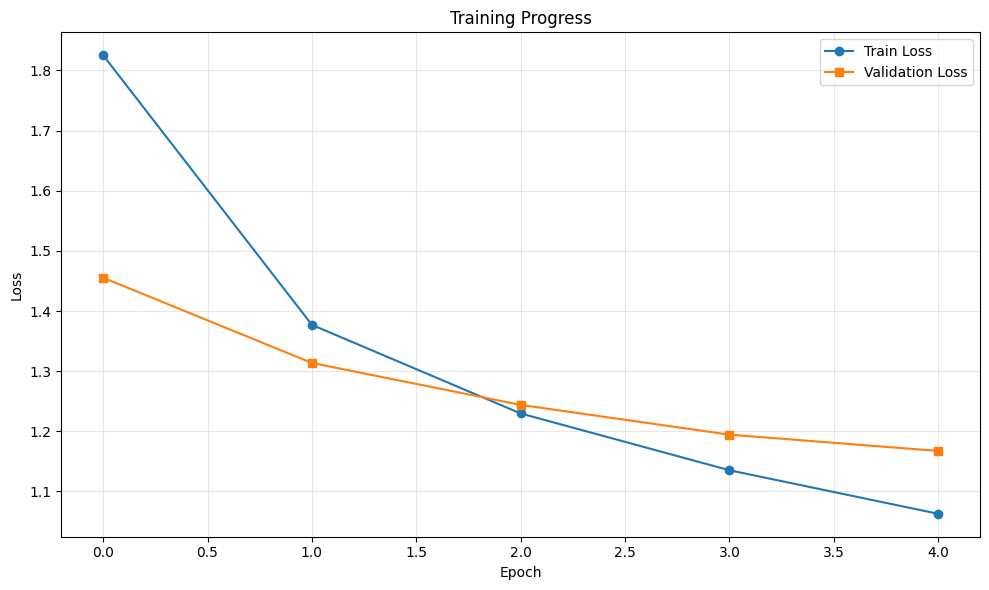

Final Train Loss: 1.0628
Final Val Loss: 1.1673


In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

## Inference / Translation Function

Generate translations using the trained model.

In [18]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, src_idx2word, tgt_idx2word, device, max_len=50):
    """
    Translate a sentence from source language to target language.
    """
    model.eval()
    
    # Encode source sentence
    tokens = tokenize(str(sentence))
    src_ids = [src_vocab["<sos>"]] + [src_vocab.get(tok, src_vocab["<unk>"]) for tok in tokens]
    
    if len(src_ids) > max_len - 1:
        src_ids = src_ids[:max_len - 1]
    
    src_ids = src_ids + [src_vocab["<eos>"]]
    
    if len(src_ids) < max_len:
        src_ids = src_ids + [src_vocab["<pad>"]] * (max_len - len(src_ids))
    
    src_tensor = torch.tensor(src_ids[:max_len], dtype=torch.long).unsqueeze(0).to(device)
    
    # Start with target start token
    tgt_ids = [tgt_vocab["<sos>"]]
    tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
    
    # Pad tgt_tensor to max_len
    while tgt_tensor.shape[1] < max_len:
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        
        # Get the last predicted token
        next_token_id = output[0, -1, :].argmax(dim=-1).item()
        
        # If EOS token or max length reached, stop
        if next_token_id == tgt_vocab["<eos>"] or tgt_tensor.shape[1] >= max_len:
            break
        
        # Add predicted token
        tgt_ids.append(next_token_id)
        tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
        
        # Pad to max_len
        if tgt_tensor.shape[1] < max_len:
            padding = torch.full((1, max_len - tgt_tensor.shape[1]), tgt_vocab["<pad>"], dtype=torch.long).to(device)
            tgt_tensor = torch.cat([tgt_tensor, padding], dim=1)
    
    # Decode target IDs to words
    translated_tokens = []
    for token_id in tgt_ids[1:]:  # Skip start token
        if token_id == tgt_vocab["<eos>"]:
            break
        if token_id != tgt_vocab["<pad>"]:
            translated_tokens.append(tgt_idx2word.get(token_id, "<unk>"))
    
    return " ".join(translated_tokens)

# Test translation on a few examples
print("=" * 80)
print("TRANSLATION EXAMPLES")
print("=" * 80)

test_sentences = [
    full_dataset['english'].iloc[0],
    full_dataset['english'].iloc[100],
    full_dataset['english'].iloc[500],
]

for idx, sentence in enumerate(test_sentences, 1):
    translation = translate_sentence(
        model, sentence, src_vocab, tgt_vocab, 
        src_idx2word, tgt_idx2word, device, max_len=MAX_LEN
    )
    print(f"\n{idx}. Source: {sentence}")
    print(f"   Target: {full_dataset['bangla'].iloc[[0, 100, 500][idx-1]]}")
    print(f"   Predicted: {translation}")

TRANSLATION EXAMPLES

1. Source: Hello, good to see you!
   Target: হ্যালো, আপনাকে দেখে ভালো লাগলো!
   Predicted: হ্যালো,

2. Source: Please open the window.
   Target: দয়া করে জানালাটি খুলুন।
   Predicted: দয়া

3. Source: A: Hi! How was your day? B: It was good, thanks!
   Target: ক: হাই! আপনার দিন কেমন গেল? খ: ভালো ছিল, ধন্যবাদ!
   Predicted: ক:


In [19]:
translate_sentence(
    model, "How are you?", src_vocab, tgt_vocab, 
    src_idx2word, tgt_idx2word, device, max_len=MAX_LEN
)

'আপনি'